# Aprendizaje basado en Ensembles: Voting, Bagging y Boosting

En este notebook vamos a ver diferentes técnicas para hacer ensemble de modelos, es decir, combinaciones de diferentes modelos para mejorar nuestras predicciones. Aquí podremos ver cómo implementar el Voting, qué es el Bagging, el Boosting; así como implementaciones de modelos basadas en estas configuraciones como Random Forest o XGBoost.

## Confuguración del entorno

In [1]:
import sys
import sklearn

import numpy as np
import os

# Semilla para poder reproducir los mismos resultados:
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# La función que hemos definido en otros ssitios para pintar:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Voting: selección de la salida por votación

La técnica más utilizada para realizar la combinación de varios modelos consiste en realizar una votación. Cada modelo, entrenado con sus correspondientes datos, devolverá una predicción (o una probabilidad de la misma) y se hará la votación:
 - **Hard voting**: los clasificadores votan una respuesta, y la decisión final lo determinará la respuesta más votada.
 - **Soft voting**: está basado en las probabilidades de las respuestas de los clasificadores. Suele funcionar mejor.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# Creamos un dataset de clasificación con la función make_moons:
X_moons, y_moons = make_moons(n_samples=500, noise=0.30, random_state=42)

# Dividimos en train/test:
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, random_state=42)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Nos vamos a crear diferentes algoritmos:
# Regresión Logística:
logreg = LogisticRegression(solver="lbfgs", random_state=42)
# Árbol de decisión:
dt = DecisionTreeClassifier(max_depth=10, random_state=42)
# SVC:
svc = SVC(gamma="scale", random_state=42)

# Y nos creamos el objeto de Voting (Hard Voting), que se encargará de gestionar por nosotros el entrenamiento y predicción con todos los algoritmos:
voting_clf = VotingClassifier(
    estimators=[('lr', logreg), ('dt', dt), ('svc', svc)], voting='hard')

In [21]:
# Etrenamos nuestro sistema de votación:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=10,
                                                     random_state=42)),
                             ('svc', SVC(random_state=42))])

In [22]:
from sklearn.metrics import accuracy_score

# Realizamos la predicción con cada algoritmo de forma individual y con el sistema de votación de todos ellos:
for clf in (logreg, dt, svc, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
DecisionTreeClassifier 0.856
SVC 0.896
VotingClassifier 0.904


In [24]:
# Repetimos lo mismo pero creando un sistema de votación "soft" (el resto es exactamente igual, podíamos haber usado los modelos definidos antes):
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
dt_clf = DecisionTreeClassifier(random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('dt', dt_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('dt', DecisionTreeClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [26]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, dt_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, f"Train: {accuracy_score(y_train, clf.predict(X_train))}", f"Test: {accuracy_score(y_test, y_pred)}")

LogisticRegression Train: 0.8426666666666667 Test: 0.864
DecisionTreeClassifier Train: 1.0 Test: 0.856
SVC Train: 0.9253333333333333 Test: 0.896
VotingClassifier Train: 0.9653333333333334 Test: 0.912


### EJERCICIO

Por mantener cierta coherencia con lo que hemos visto en clases pasadas, vamos a repetir estos ejercicios sobre el mismo dataset, que ya lo tenemos más que conocido.

1. Prueba a combinar los algoritmos Regresión Logística, Árbol de decisión y KNN, y qué salida consigues:

In [29]:
import pandas as pd
df = pd.read_csv("../../../data/titanic.csv", sep='\t')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
151,152,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.0,1,0,113776,66.6000,C2,S
152,153,0,3,"Meo, Mr. Alfonzo",male,55.5,0,0,A.5. 11206,8.0500,NaN,S
153,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.5000,NaN,S
154,155,0,3,"Olsen, Mr. Ole Martin",male,NaN,0,0,Fa 265302,7.3125,NaN,S


In [49]:
# El que queda de Embarked, lo vamos a rellenar con "S" porque es el mayoritario.
df['Embarked'] = df['Embarked'].fillna('S')

# En Age, vamos a completar los valores nulos con la media de los valores de Age.
df['Age'] = df['Age'].fillna(df['Age'].mean())

# En Pclass, vamos a convertirlo a string para luego hacer el One Hot Encoding.
df['Pclass'] = df['Pclass'].astype(str)

# Separamos las variables que podemos utilizar para predecir de la que queremos predecir:
y_col = 'Survived'
X_cols = [col for col in df.columns if col not in ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived']]

X = df[X_cols]
y = df[y_col]

# Tratamiento categóricas:
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [52]:
# Repetimos lo mismo pero creando un sistema de votación "soft" (el resto es exactamente igual, podíamos haber usado los modelos definidos antes):
log_clf = LogisticRegression(max_iter=2000, solver="lbfgs", random_state=42)
dt_clf = DecisionTreeClassifier(random_state=42)
# svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('dt', dt_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=2000,
                                                 random_state=42)),
                             ('dt', DecisionTreeClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [53]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, dt_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, f"\n\tTrain: {accuracy_score(y_train, clf.predict(X_train))}", f"\n\tTest: {accuracy_score(y_test, y_pred)}")

LogisticRegression 
	Train: 0.8623853211009175 
	Test: 0.7659574468085106
DecisionTreeClassifier 
	Train: 1.0 
	Test: 0.7659574468085106
SVC 
	Train: 0.6422018348623854 
	Test: 0.6808510638297872
VotingClassifier 
	Train: 0.981651376146789 
	Test: 0.7872340425531915


## Bagging ensembles

El "bagging" sería el siguiente paso, que consiste en utilizar unas cuantas instancias del mismo modelo pero entrenados con muestreos diferentes de los datos originales. Tras ello, cada predicción se hará mediante la votación de cada uno de los modelos que acabos de entrenar, de modo que cada uno pueda aportar "su punto de vista":

In [54]:
# Antes de nada, volvemos a crearnos X_train y X_test, por si las hemos sobreescrito en el ejercicio anterior:
X = X_moons
y = y_moons
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [55]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Nos creamos el bagging con árboles de decisión:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=500,
    max_samples=100, 
    bootstrap=True, 
    random_state=42)

# Lo ajustamos:
bag_clf.fit(X_train, y_train)

# Y predecimos:
y_pred = bag_clf.predict(X_test)

In [67]:
from sklearn.metrics import accuracy_score

# Y calculamos el accuracy:
print(accuracy_score(y_test, y_pred))

0.904


In [68]:
# Si lo comparamos con un solo decisor:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


A continuación, vamos a representar un par de figuras para entender qué está pasando, pero no hay que saberse cómo se hace esta representación. Lo importante es lo anterior: saber crearse los objetos y entender qué están haciendo.

In [69]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


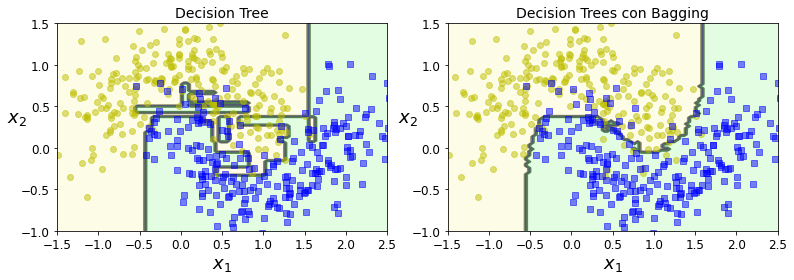

In [70]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees con Bagging", fontsize=14)
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

### EJERCICIO

1. Prueba a utilizar la técnica de bagging con árboles de decisión y con regresores logísticos, variando el número de instancias utilizadas para el bagging. Prueba pocas combinaciones, como 20, 50 y 100, por ejemplo, para cada uno de los algoritmos. ¿Con cuál obtienes mejor score sobre test?

Utiliza el dataset del Titanic.

In [100]:
import pandas as pd
df = pd.read_csv("../../../data/titanic.csv", sep='\t')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
151,152,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.0,1,0,113776,66.6000,C2,S
152,153,0,3,"Meo, Mr. Alfonzo",male,55.5,0,0,A.5. 11206,8.0500,NaN,S
153,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.5000,NaN,S
154,155,0,3,"Olsen, Mr. Ole Martin",male,NaN,0,0,Fa 265302,7.3125,NaN,S


In [104]:
# El que queda de Embarked, lo vamos a rellenar con "S" porque es el mayoritario.
df['Embarked'] = df['Embarked'].fillna('S')

# En Age, vamos a completar los valores nulos con la media de los valores de Age.
df['Age'] = df['Age'].fillna(df['Age'].mean())

# En Pclass, vamos a convertirlo a string para luego hacer el One Hot Encoding.
df['Pclass'] = df['Pclass'].astype(str)

# Separamos las variables que podemos utilizar para predecir de la que queremos predecir:
y_col = 'Survived'
X_cols = [col for col in df.columns if col not in ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived']]

X = df[X_cols]
y = df[y_col]

# Tratamiento categóricas:
X = pd.get_dummies(X)

In [117]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

bag_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42), 
    n_estimators=500,
    max_samples=100, 
    bootstrap=True, 
    random_state=42)

pipe = Pipeline([('scaler', MinMaxScaler()), ('bag', bag_clf)])

params = {
    'bag__base_estimator': [LogisticRegression(max_iter=2000, C=2, solver='liblinear'), DecisionTreeClassifier(max_depth=5)],
    'bag__n_estimators': [20, 50, 100]
}

gs_pipe = GridSearchCV(pipe,
                      params,
                      cv = 10,
                      scoring='accuracy',
                      n_jobs=-1,
                      verbose=1)

In [118]:
gs_pipe.fit(X_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  60 | elapsed:    1.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.9s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('bag',
                                        BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                                                          max_samples=100,
                                                          n_estimators=500,
                                                          random_state=42))]),
             n_jobs=-1,
             param_grid={'bag__base_estimator': [LogisticRegression(C=2,
                                                                    max_iter=2000,
                                                                    solver='liblinear'),
                                                 DecisionTreeClassifier(max_depth=5)],
                         'bag__n_estimators': [20, 50, 100]},
             scoring='accuracy', verbose=1)

In [119]:
gs_pipe.best_estimator_.score(X_test, y_test)

0.717948717948718

In [120]:
gs_pipe.best_score_

0.8287878787878787

In [103]:
X_train.shape

(375, 2)

Otra opción con Pipelines:

In [133]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest

bag_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42), 
    n_estimators=500,
    max_samples=100, 
    bootstrap=True, 
    random_state=42)

pipe = Pipeline([('scaler', StandardScaler()), ('selector', SelectKBest()), ('bag', bag_clf)])

params = {
    'selector__k': np.arange(1, 6),
    'bag__base_estimator': [LogisticRegression(max_iter=2000), DecisionTreeClassifier(max_depth=5)],
    'bag__n_estimators': [20, 50, 100]
}

gs_pipe = GridSearchCV(pipe,
                      params,
                      cv = 10,
                      scoring='accuracy',
                      n_jobs=-1,
                      verbose=1)

In [134]:
gs_pipe.fit(X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   15.4s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selector', SelectKBest()),
                                       ('bag',
                                        BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                                                          max_samples=100,
                                                          n_estimators=500,
                                                          random_state=42))]),
             n_jobs=-1,
             param_grid={'bag__base_estimator': [LogisticRegression(max_iter=2000),
                                                 DecisionTreeClassifier(max_depth=5)],
                         'bag__n_estimators': [20, 50, 100],
                         'selector__k': array([1, 2, 3, 4, 5])},
             scoring='accuracy', verbose=1)

In [138]:
# gs_pipe.best_score_
gs_pipe.best_estimator_.score(X_test, y_test)

0.717948717948718

# Random Forests

Esta fórmula, aplicada a los árboles de decisión (como acabamos de ver), y haciendo las divisiones de los árboles de decisión de manera aleatoria (y no eligiendo la mejor en cada corte), es lo que da origen al modelo Random Forest:

In [139]:
# Implementamos RandomForest, creando un bagging de n árboles de decisión seleccionando variables de forma aleatoria:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

In [140]:
# Entrenamos y predecimos:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [147]:
bag_clf.score(X_test, y_test)

0.6923076923076923

In [144]:
from sklearn.ensemble import RandomForestClassifier

# Y ahora probaremos con el Radnom Forest de sklearn (que, pese a que se basa en la misma idea, tiene ligeras mejoras):
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [148]:
rnd_clf.score(X_test, y_test)

0.717948717948718

## Feature importance (Importancia de variables)

Anteriormente, hemos visto cómo realizar una selección de variables. Sin embargo, el modelo RandomForest es capaz de obtener la importancia de las diferentes variables, en base a cómo le afectan a cada uno de sus árboles:

In [149]:
from sklearn.datasets import load_iris

# Leemos el dataset de sklearn:
iris = load_iris()

# Creamos el Random Forest:
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)

# Entrenamos:
rnd_clf.fit(iris["data"], iris["target"])

# Obtenemos la importancia de las variables, iterando junto las columnas para mantener la relación, y las vamos imprimiendo:
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [154]:
pd.DataFrame({'importances': rnd_clf.feature_importances_, 'variables': iris.feature_names}).sort_values(by='importances', ascending=False)

,importances,variables
2,0.441030,petal length (cm)
3,0.423358,petal width (cm)
0,0.112492,sepal length (cm)
1,0.023119,sepal width (cm)


Veamos un ejemplo para un set de imágenes con trazos de números:

In [155]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [156]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [157]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


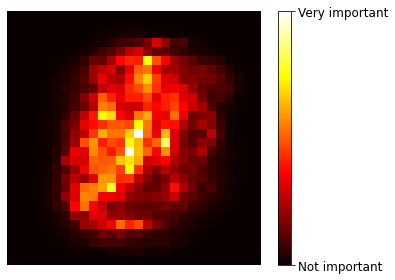

In [158]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

### EJERCICIO

1. Prueba este modelo sobre el dataset del Titanic para ver si una persona ha sobrevivido o no.
2. Obtén la importancia de las variables.

In [159]:
import pandas as pd
df = pd.read_csv("../../../data/titanic.csv", sep='\t')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
151,152,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.0,1,0,113776,66.6000,C2,S
152,153,0,3,"Meo, Mr. Alfonzo",male,55.5,0,0,A.5. 11206,8.0500,NaN,S
153,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.5000,NaN,S
154,155,0,3,"Olsen, Mr. Ole Martin",male,NaN,0,0,Fa 265302,7.3125,NaN,S


In [240]:
# El que queda de Embarked, lo vamos a rellenar con "S" porque es el mayoritario.
df['Embarked'] = df['Embarked'].fillna('S')

# En Age, vamos a completar los valores nulos con la media de los valores de Age.
df['Age'] = df['Age'].fillna(df['Age'].mean())

# En Pclass, vamos a convertirlo a string para luego hacer el One Hot Encoding.
df['Pclass'] = df['Pclass'].astype(str)

df['Sex'] = df['Sex'].apply(lambda x: x=='male')

# Separamos las variables que podemos utilizar para predecir de la que queremos predecir:
y_col = 'Survived'
X_cols = [col for col in df.columns if col not in ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived']]

X = df[X_cols]
y = df[y_col]

# Tratamiento categóricas:
X = pd.get_dummies(X)

# Dividimos en train/test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [245]:
# Creamos el modelo:
rnd_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=32, random_state=42)

# Entrenamos:
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=32, random_state=42)

In [246]:
# Calculamos score:
rnd_clf.score(X_test, y_test)

0.7872340425531915

In [247]:
# Calculamos score:
rnd_clf.score(X_train, y_train)

1.0

In [248]:
pd.DataFrame({'importances': rnd_clf.feature_importances_, 'variables': X.columns}).sort_values(by='importances', ascending=False)

,importances,variables
0,0.311629,Sex
4,0.255280,Fare
1,0.214211,Age
2,0.053392,SibSp
3,0.044047,Parch
7,0.030585,Pclass_3
10,0.021902,Embarked_S
8,0.019101,Embarked_C
9,0.018290,Embarked_Q
5,0.015871,Pclass_1


## AdaBoost

Otros de los modelos de ensemble más utilziados es AdaBoost, que se trata de un algoritmo de boosting, donde se colocan en serie los modelos para generar su salida en base a la salida del anterior:

In [249]:
# Antes de nada, volvemos a crearnos X_train y X_test, por si las hemos sobreescrito en el ejercicio anterior:
X = X_moons
y = y_moons
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [264]:
from sklearn.ensemble import AdaBoostClassifier

# Creamos clasificador:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=2000,
    algorithm="SAMME.R",
    learning_rate=0.5,
    random_state=42)

# Entrenamos:
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=2000, random_state=42)

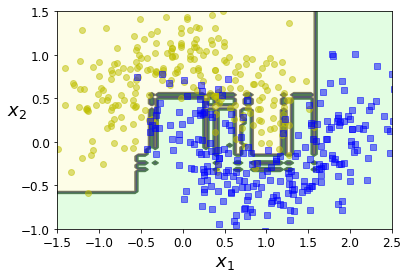

In [265]:
# Utilizamos la función diseñada anteriormente para pintar (pero no te aprendas esa función, esto es algo puntual)
plot_decision_boundary(ada_clf, X, y)

Saving figure boosting_plot


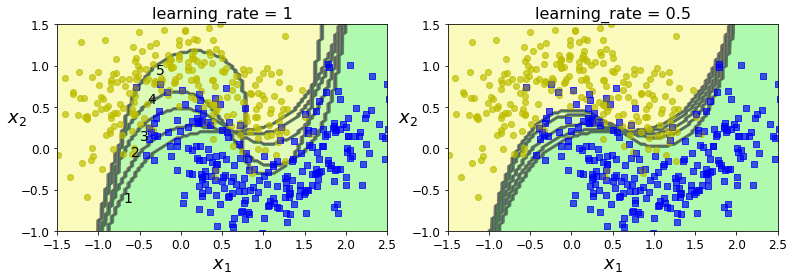

In [252]:
# Y nos creamos otra visualización variando diferentes parámetros:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

save_fig("boosting_plot")
plt.show()

### EJERCICIO

¿Qué resultados conseguimos si utilizamos un modelo AdaBoost sobre nuestros datos del Titanic?

In [269]:
import pandas as pd
df = pd.read_csv("../../../data/titanic.csv", sep='\t')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
151,152,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.0,1,0,113776,66.6000,C2,S
152,153,0,3,"Meo, Mr. Alfonzo",male,55.5,0,0,A.5. 11206,8.0500,NaN,S
153,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.5000,NaN,S
154,155,0,3,"Olsen, Mr. Ole Martin",male,NaN,0,0,Fa 265302,7.3125,NaN,S


In [297]:
# El que queda de Embarked, lo vamos a rellenar con "S" porque es el mayoritario.
df['Embarked'] = df['Embarked'].fillna('S')

# En Age, vamos a completar los valores nulos con la media de los valores de Age.
df['Age'] = df['Age'].fillna(df['Age'].mean())

# En Pclass, vamos a convertirlo a string para luego hacer el One Hot Encoding.
df['Pclass'] = df['Pclass'].astype(str)

# Separamos las variables que podemos utilizar para predecir de la que queremos predecir:
y_col = 'Survived'
X_cols = [col for col in df.columns if col not in ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived']]

X = df[X_cols]
y = df[y_col]

# Tratamiento categóricas:
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [284]:
from sklearn.ensemble import AdaBoostClassifier

# Creamos clasificador:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=3),
    n_estimators=500,
    algorithm="SAMME.R",
    learning_rate=0.85,
    random_state=42)

pipe = Pipeline([('booster', ada_clf)])

params = {
    'booster__n_estimators': [10, 50, 75, 100, 200, 500, 1000],
    'booster__learning_rate': np.arange(0.5, 1, 0.05)
}

# Entrenamos:
gs_ada = GridSearchCV(pipe,
                      params,
                      cv=10,
                      scoring='accuracy',
                      n_jobs=-1,
                      verbose=1)
gs_ada.fit(X_train, y_train)

Fitting 10 folds for each of 70 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  1.7min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('booster',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                                           learning_rate=0.85,
                                                           n_estimators=500,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'booster__learning_rate': array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                         'booster__n_estimators': [10, 50, 75, 100, 200, 500,
                                                   1000]},
             scoring='accuracy', verbose=1)

In [286]:
gs_ada.score(X_test, y_test)

0.7435897435897436

In [287]:
from sklearn.ensemble import RandomForestClassifier

# Y ahora probaremos con el Radnom Forest de sklearn (que, pese a que se basa en la misma idea, tiene ligeras mejoras):
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, random_state=42)

In [325]:
from sklearn.ensemble import AdaBoostClassifier

# Creamos clasificador:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(), n_estimators=100,
    algorithm="SAMME.R", learning_rate=1, random_state=42)

# Entrenamos:
ada_clf.fit(X_train, y_train)
print('score_train :', ada_clf.score(X_train, y_train))
print('score_test :',ada_clf.score(X_test, y_test))

score_train : 1.0
score_test : 0.7021276595744681


In [326]:
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=1,
                   n_estimators=100, random_state=42)

In [324]:
ada_clf.feature_importances_

array([0.11559999, 0.10424373, 0.03787645, 0.29519457, 0.        ,
       0.        , 0.00961942, 0.39362297, 0.        , 0.        ,
       0.02126397, 0.02257891])

## Gradient Boosting

Otro modelo es el Gradient Boosting, que a diferencia del AdaBoost, no se encarga de actualizar los pesos de cada registro en cada iteración, sino que busca minimizar errores:

In [327]:
# Nos creamos datos pseudo-aleatorios:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

Vamos a hacerlo de forma "manual", entrenando uno a uno de forma secuencial. Además, crearemos un modelo de regresión, que se obtendrá con la media de los valores:

In [334]:
from sklearn.tree import DecisionTreeRegressor

# Nos creamos el primer árbol de decisión:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)

# Y entrenamos:
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [335]:
# Ahora nos entrará el error de la salida (predicción) del primero:
y2 = y - tree_reg1.predict(X)
y2

array([-0.07199323,  0.06591133,  0.04248548, -0.19374408,  0.22041981,
        0.24930881, -0.00114735, -0.15222706, -0.13331807, -0.01877138,
        0.07437546,  0.1503149 , -0.22350214,  0.15034361,  0.18499381,
        0.22556424, -0.04370548, -0.13811059, -0.12927709, -0.06598606,
       -0.0712269 , -0.08485003,  0.00630109, -0.08171801, -0.18854512,
        0.0993776 ,  0.12988566, -0.16307213, -0.10600905, -0.0235881 ,
        0.00544086,  0.21082582, -0.08049446,  0.07220392,  0.02593255,
        0.16043495, -0.00602728,  0.12096847, -0.03135875, -0.09774359,
       -0.06096712, -0.18193024,  0.04661096,  0.01165776,  0.09054676,
       -0.08979502,  0.05293175, -0.1924505 , -0.08767772,  0.2839068 ,
        0.08343389,  0.0752132 ,  0.05589207, -0.08607633, -0.17234608,
        0.0087933 , -0.03289674,  0.17739276, -0.08642889,  0.04545908,
       -0.12555055,  0.01717459, -0.16368755, -0.12355051,  0.03177594,
       -0.05274012,  0.18286595,  0.15963461,  0.06821878,  0.22

In [336]:
# Nos creamos otro árbol:
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)

# Y lo entrenamos:
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [337]:
# Ahora hacemos lo propio para el siguiente modelo:
y3 = y2 - tree_reg2.predict(X)
y3

array([ 0.01840471,  0.02599835,  0.00257251, -0.10334615,  0.06058178,
        0.08947079, -0.00114735, -0.19214004, -0.04292013, -0.05868436,
        0.07437546,  0.11040193, -0.26341512, -0.00949442,  0.02515578,
        0.06572621,  0.04669245, -0.04771265, -0.03887916,  0.02441188,
        0.01917103, -0.08485003,  0.09669902,  0.00867992, -0.09814719,
        0.05946462, -0.02995236, -0.0726742 , -0.01561112, -0.0235881 ,
        0.09583879,  0.0509878 , -0.08049446,  0.03229094, -0.01398043,
        0.12052198,  0.08437066,  0.12096847,  0.05903919, -0.00734565,
       -0.06096712, -0.0915323 ,  0.04661096, -0.02825521, -0.06929126,
        0.00060292,  0.14332968, -0.10205257,  0.00272022,  0.12406878,
        0.04352092,  0.03530023,  0.01597909, -0.12598931, -0.08194814,
       -0.03111968, -0.03289674,  0.01755473, -0.08642889,  0.13585701,
       -0.03515262, -0.14266343, -0.20360053, -0.03315258, -0.12806208,
        0.03765781,  0.02302793,  0.11972164,  0.06821878,  0.18

In [338]:
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Y así podríamos seguir hasta que queramos. Vamos a probar con un ejemplo:

In [339]:
X_new = np.array([[0.8]])

In [340]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [341]:
y_pred

array([0.75026781])

Y representacmos gráficamente (no te tienes que aprender esto, repito):

In [342]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


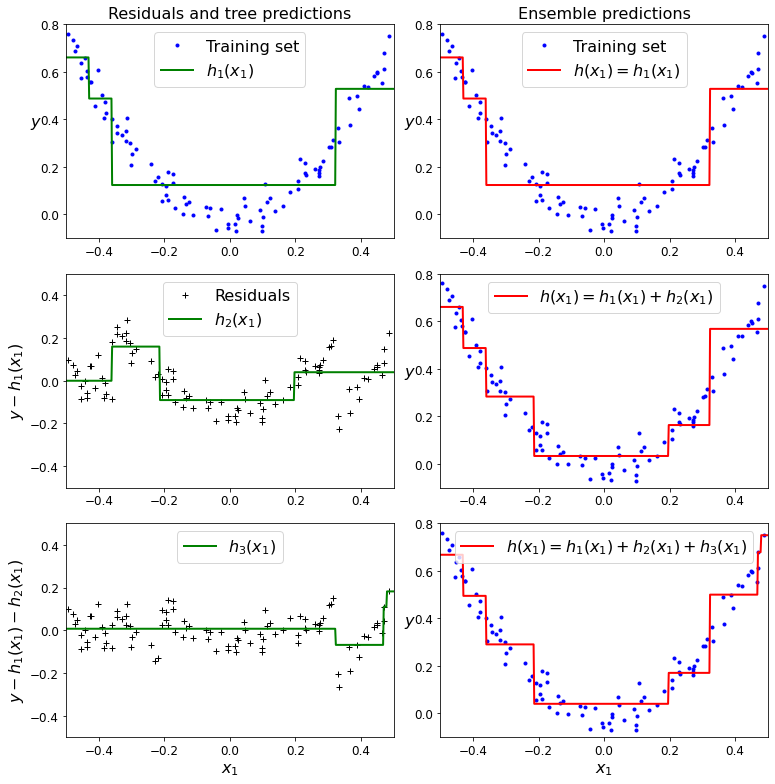

In [343]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

También podemos utilizar el objeto ya definido en ``sklearn``:

In [347]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [350]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y, gbrt.predict(X))

0.005038058938993283

In [351]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

In [352]:
mean_squared_error(y, gbrt_slow.predict(X))

0.00034856797707401353

Saving figure gbrt_learning_rate_plot


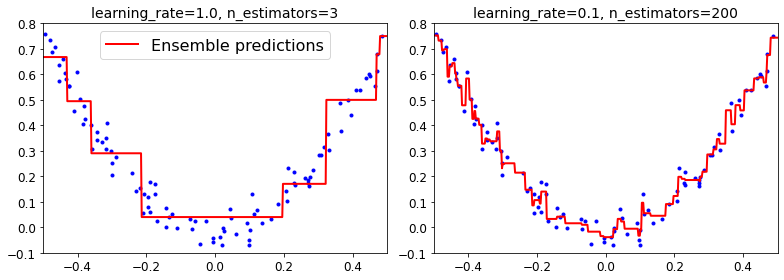

In [353]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

save_fig("gbrt_learning_rate_plot")
plt.show()

## XGBoost

Finalmente, tenemos XGBoost, otro de los algoritmos de boosting más utilizados, basado en el descenso de gradiente par aencontrar su mejor versión:

In [357]:
try:
    import xgboost
except ImportError as ex:
    print("Error: no tienes instalada la librería de xgboost.")
    xgboost = None

In [358]:
from sklearn.metrics import mean_squared_error

if xgboost is not None:
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred)
    print("Validación MSE:", val_error)

Validación MSE: 0.19734758127509033


In [364]:
if xgboost is not None:
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_test, y_test)], early_stopping_rounds=10)
    y_pred = xgb_reg.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred)
    print("Validación MSE:", val_error)

[0]	validation_0-rmse:0.43812
[1]	validation_0-rmse:0.42592
[2]	validation_0-rmse:0.42838
[3]	validation_0-rmse:0.44191
[4]	validation_0-rmse:0.44298
[5]	validation_0-rmse:0.44381
[6]	validation_0-rmse:0.44819
[7]	validation_0-rmse:0.44803
[8]	validation_0-rmse:0.44687
[9]	validation_0-rmse:0.44586
[10]	validation_0-rmse:0.44449
[11]	validation_0-rmse:0.44457
Validación MSE: 0.18140502458231536


### EJERCICIO

El modelo xgboost también tiene versión de clasificación, xgboost.XGBClassifier. Investiga y utiliza este algoritmo sobre el dataset del Titanic que ya tenemos muy visto para predecir la gente que ha muerto:

In [149]:
import pandas as pd
df = pd.read_csv("../../../data/titanic.csv", sep='\t')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
151,152,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.0,1,0,113776,66.6000,C2,S
152,153,0,3,"Meo, Mr. Alfonzo",male,55.5,0,0,A.5. 11206,8.0500,NaN,S
153,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.5000,NaN,S
154,155,0,3,"Olsen, Mr. Ole Martin",male,NaN,0,0,Fa 265302,7.3125,NaN,S


In [151]:
# El que queda de Embarked, lo vamos a rellenar con "S" porque es el mayoritario.
df['Embarked'] = df['Embarked'].fillna('S')

# En Age, vamos a completar los valores nulos con la media de los valores de Age.
df['Age'] = df['Age'].fillna(df['Age'].mean())

# En Pclass, vamos a convertirlo a string para luego hacer el One Hot Encoding.
df['Pclass'] = df['Pclass'].astype(str)

# Separamos las variables que podemos utilizar para predecir de la que queremos predecir:
y_col = 'Survived'
X_cols = [col for col in df.columns if col not in ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived']]

X = df[X_cols]
y = df[y_col]

# Tratamiento categóricas:
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)